In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

['ID', 'inputs', 'outputs']
[[ 0.         -0.26826759  1.07764198  1.05265014 -1.3270583  -0.94661403
   1.12673937  0.71787569]
 [ 0.         -0.91817119  1.07764198  1.05265014 -1.3270583  -0.94661403
   1.12673937  0.71787569]
 [ 0.          1.37337268  1.07764198  1.05265014 -1.3270583  -0.94661403
   1.12673937  0.71787569]
 [ 0.          0.83822596  1.07764198  1.05265014 -1.3270583  -0.94661403
   1.12673937  0.71787569]
 [ 0.         -1.14781675  1.07764198  1.05265014 -1.3270583  -0.94661403
   1.12673937  0.71787569]
 [ 0.         -0.24998136  1.07764198  1.05265014 -1.3270583  -0.94661403
   1.12673937  0.71787569]
 [ 0.          1.01510858  1.07764198  1.05265014 -1.3270583  -0.94661403
   1.12673937  0.71787569]
 [ 0.         -0.07982097  1.07764198  1.05265014 -1.3270583  -0.94661403
   1.12673937  0.71787569]
 [ 0.         -0.52648728  1.07764198  1.05265014 -1.3270583  -0.94661403
   1.12673937  0.71787569]
 [ 0.          0.57107783  1.07764198  1.05265014 -1.3270583  -

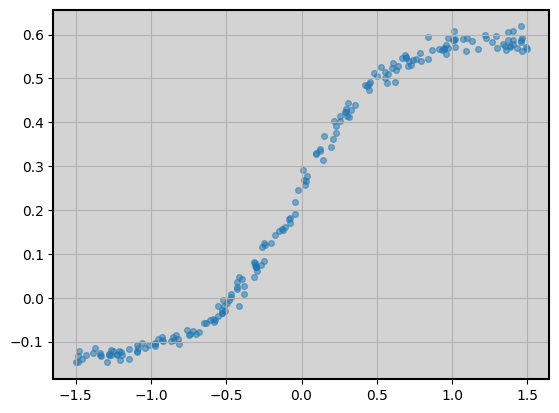

In [37]:
batch = np.load("currentData/batch_test.npz")
print(batch.files)
inputs = batch["inputs"]
outputs = batch["outputs"]

print(inputs[:10, :])

plt.scatter(
    inputs[:, 1], 
    outputs,
    alpha=0.5,
    s=17)

ax = plt.gca()
ax.grid(True)
ax.spines[["top", "bottom", "left", "right"]].set_linewidth(1.5)
ax.set_facecolor("lightgrey")

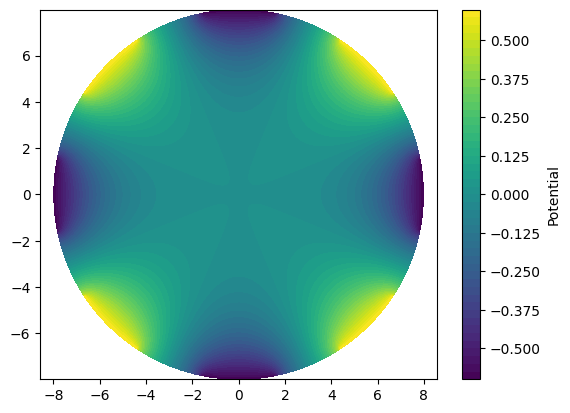

In [2]:
df = pd.read_csv("potential.csv")
plt.tricontourf(df.x, df.y, df.potential, levels=50)
plt.colorbar(label="Potential")
plt.axis("equal")
plt.show()


(100,)


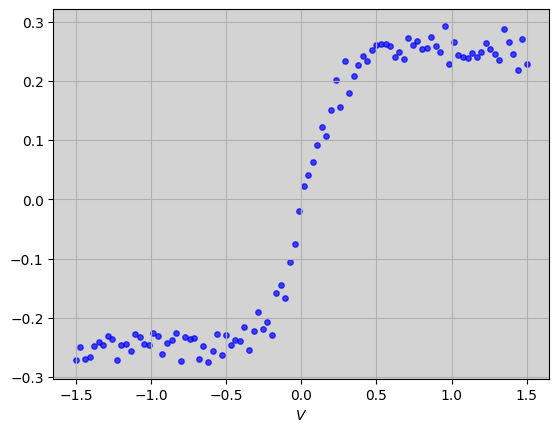

In [22]:
data = np.genfromtxt("iv_curve.csv", delimiter=",")
print(data.shape)

vs = np.linspace(-1.5, 1.5, len(data))

fig, ax = plt.subplots()

ax.set_facecolor("lightgrey")
ax.grid(True)
ax.set_xlabel("$V$")
ax.scatter(vs, data, s=15, alpha=.7, color="blue")